In [1]:
import sys

IN_COLAB = "google.colab" in sys.modules
IN_COLAB

False

In [2]:
if IN_COLAB:
    from google.colab import drive

    drive.mount("/content/drive")

In [3]:
if IN_COLAB:
    # Put here the full path to the folder having your Sprint project code
    # e.g. "/content/drive/MyDrive/assignment"
    ROOT_DIR = "/content/drive/MyDrive/'Colab Notebooks'/AnyoneAI/final_project/main"
    %cd $ROOT_DIR

In [4]:
pip install boto3 python_dotenv

Note: you may need to restart the kernel to use updated packages.


In [5]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from src import config, data_utils, evaluation, plot

In [6]:
dataset = pd.read_csv("clean_data.csv")

In [7]:
dataset.head()

,PAYMENT_DAY,APPLICATION_SUBMISSION_TYPE,SEX,MARITAL_STATUS,QUANT_DEPENDANTS,RESIDENCIAL_STATE,FLAG_RESIDENCIAL_PHONE,MONTHS_IN_RESIDENCE,FLAG_EMAIL,COMPANY,...,PRODUCT,AGE,TARGET_LABEL_BAD=1,HAS_DEPENDANTS,HAS_RESIDENCE,MONTHLY_INCOMES_TOT,HAS_CARDS,HAS_BANKING_ACCOUNTS,HAS_PERSONAL_ASSETS,HAS_CARS
0,1 - 14,Web,F,other,1,RN,Y,+ 1 year,1,N,...,1,26 - 35,1,True,True,[650 - 1320],True,False,False,False
1,15 - 30,Carga,F,married,0,RJ,Y,0 - 6 months,1,Y,...,1,26 - 35,1,False,True,[650 - 1320],False,False,False,False
2,1 - 14,Web,F,married,0,RN,Y,+ 1 year,1,N,...,1,26 - 35,0,False,True,[0 - 650],False,False,False,False
3,15 - 30,Web,F,married,0,PE,N,+ 1 year,1,N,...,1,> 60,0,False,False,[0 - 650],False,False,False,False
4,1 - 14,Web,M,married,0,RJ,Y,6 months - 1 year,1,N,...,1,46 - 60,1,False,True,[650 - 1320],False,False,False,False


In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49935 entries, 0 to 49934
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   PAYMENT_DAY                  49935 non-null  object
 1   APPLICATION_SUBMISSION_TYPE  49935 non-null  object
 2   SEX                          49935 non-null  object
 3   MARITAL_STATUS               49935 non-null  object
 4   QUANT_DEPENDANTS             49935 non-null  int64 
 5   RESIDENCIAL_STATE            49935 non-null  object
 6   FLAG_RESIDENCIAL_PHONE       49935 non-null  object
 7   MONTHS_IN_RESIDENCE          49935 non-null  object
 8   FLAG_EMAIL                   49935 non-null  int64 
 9   COMPANY                      49935 non-null  object
 10  FLAG_PROFESSIONAL_PHONE      49935 non-null  object
 11  PRODUCT                      49935 non-null  int64 
 12  AGE                          49935 non-null  object
 13  TARGET_LABEL_BAD=1           49

In [9]:
dataset['MONTHLY_INCOMES_TOT'] = dataset['MONTHLY_INCOMES_TOT'].apply(lambda x: 0 if x == '[0-650]' else x)
dataset['MONTHLY_INCOMES_TOT'] = dataset['MONTHLY_INCOMES_TOT'].apply(lambda x: 1 if x == '[650-1320]' else x)
dataset['MONTHLY_INCOMES_TOT'] = dataset['MONTHLY_INCOMES_TOT'].apply(lambda x: 2 if x == '[1320-3323]' else x)
dataset['MONTHLY_INCOMES_TOT'] = dataset['MONTHLY_INCOMES_TOT'].apply(lambda x: 3 if x == '[3323-8560]' else x)
dataset['MONTHLY_INCOMES_TOT'] = dataset['MONTHLY_INCOMES_TOT'].apply(lambda x: 4 if x == '[>8560]' else x)

In [10]:
dataset = dataset.drop(columns=['APPLICATION_SUBMISSION_TYPE','SEX'])

In [11]:
# perform random downsampling
sample_size = dataset['TARGET_LABEL_BAD=1'].value_counts().min()
dataset_resampled = pd.concat([dataset[dataset['TARGET_LABEL_BAD=1'] == c].sample(sample_size) for c in dataset['TARGET_LABEL_BAD=1'].unique()])
print('Resampled dataset shape %s' % dataset_resampled['TARGET_LABEL_BAD=1'].value_counts())

Resampled dataset shape TARGET_LABEL_BAD=1
1    13018
0    13018
Name: count, dtype: int64


In [12]:
# first split in sets
app_train_set, app_val_set, app_test_set = data_utils.get_feature_in_set(dataset)

In [13]:
# second split features and target
train_prep, y_train, val_prep, y_val, test_prep, y_test = data_utils.get_feature_target(app_train_set,app_val_set,app_test_set)

In [14]:
# third apply preprocess in sets
X_train, X_val, X_test, columns = data_utils.preprocess_data(train_prep,val_prep,test_prep)

Input train data shape:  (35953, 18)
Input val data shape:  (3995, 18)
Input test data shape:  (9987, 18) 

cat_cols:  Index(['PAYMENT_DAY', 'MARITAL_STATUS', 'RESIDENCIAL_STATE',
       'FLAG_RESIDENCIAL_PHONE', 'MONTHS_IN_RESIDENCE', 'COMPANY',
       'FLAG_PROFESSIONAL_PHONE', 'AGE', 'HAS_DEPENDANTS', 'HAS_RESIDENCE',
       'MONTHLY_INCOMES_TOT', 'HAS_CARDS', 'HAS_BANKING_ACCOUNTS',
       'HAS_PERSONAL_ASSETS', 'HAS_CARS'],
      dtype='object')
['QUANT_DEPENDANTS', 'FLAG_EMAIL', 'PRODUCT']
Index(['PAYMENT_DAY', 'FLAG_RESIDENCIAL_PHONE', 'COMPANY',
       'FLAG_PROFESSIONAL_PHONE', 'HAS_DEPENDANTS', 'HAS_RESIDENCE',
       'HAS_CARDS', 'HAS_BANKING_ACCOUNTS', 'HAS_PERSONAL_ASSETS', 'HAS_CARS'],
      dtype='object')
Index(['MARITAL_STATUS', 'RESIDENCIAL_STATE', 'MONTHS_IN_RESIDENCE', 'AGE',
       'MONTHLY_INCOMES_TOT'],
      dtype='object')


In [15]:
columns

['transform_cat__MARITAL_STATUS_married',
 'transform_cat__MARITAL_STATUS_other',
 'transform_cat__MARITAL_STATUS_single',
 'transform_cat__RESIDENCIAL_STATE_AC',
 'transform_cat__RESIDENCIAL_STATE_AL',
 'transform_cat__RESIDENCIAL_STATE_AM',
 'transform_cat__RESIDENCIAL_STATE_AP',
 'transform_cat__RESIDENCIAL_STATE_BA',
 'transform_cat__RESIDENCIAL_STATE_CE',
 'transform_cat__RESIDENCIAL_STATE_DF',
 'transform_cat__RESIDENCIAL_STATE_ES',
 'transform_cat__RESIDENCIAL_STATE_GO',
 'transform_cat__RESIDENCIAL_STATE_MA',
 'transform_cat__RESIDENCIAL_STATE_MG',
 'transform_cat__RESIDENCIAL_STATE_MS',
 'transform_cat__RESIDENCIAL_STATE_MT',
 'transform_cat__RESIDENCIAL_STATE_PA',
 'transform_cat__RESIDENCIAL_STATE_PB',
 'transform_cat__RESIDENCIAL_STATE_PE',
 'transform_cat__RESIDENCIAL_STATE_PI',
 'transform_cat__RESIDENCIAL_STATE_PR',
 'transform_cat__RESIDENCIAL_STATE_RJ',
 'transform_cat__RESIDENCIAL_STATE_RN',
 'transform_cat__RESIDENCIAL_STATE_RO',
 'transform_cat__RESIDENCIAL_STATE_RR

In [16]:
pd.DataFrame(X_train, columns=columns)

,transform_cat__MARITAL_STATUS_married,transform_cat__MARITAL_STATUS_other,transform_cat__MARITAL_STATUS_single,transform_cat__RESIDENCIAL_STATE_AC,transform_cat__RESIDENCIAL_STATE_AL,transform_cat__RESIDENCIAL_STATE_AM,transform_cat__RESIDENCIAL_STATE_AP,transform_cat__RESIDENCIAL_STATE_BA,transform_cat__RESIDENCIAL_STATE_CE,transform_cat__RESIDENCIAL_STATE_DF,...,transform_bin__FLAG_PROFESSIONAL_PHONE,transform_bin__HAS_DEPENDANTS,transform_bin__HAS_RESIDENCE,transform_bin__HAS_CARDS,transform_bin__HAS_BANKING_ACCOUNTS,transform_bin__HAS_PERSONAL_ASSETS,transform_bin__HAS_CARS,transform_num__QUANT_DEPENDANTS,transform_num__FLAG_EMAIL,transform_num__PRODUCT
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,-1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35948,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
35949,-1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35950,-1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
35951,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
input_shape = X_train.shape

In [18]:
model = Sequential()
model.add(layers.Dense(20, input_dim=input_shape[1], activation='relu'))
# model.add(layers.Dropout(0.5))
model.add(layers.Dense(15, activation='relu'))
# model.add(layers.Dense(100, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
# model.add(layers.Dropout(0.5)) # added dropout layer
#model.add(layers.Dense(50, activation='relu'))
#Dropout.
#model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                1160      
                                                                 
 dense_1 (Dense)             (None, 15)                315       
                                                                 
 dense_2 (Dense)             (None, 1)                 16        
                                                                 
Total params: 1491 (5.82 KB)
Trainable params: 1491 (5.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(lr=0.000001),
    metrics=['accuracy']
)

In [20]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(patience=10)


history = model.fit(
    X_train,
    y_train,
    shuffle=True,
    epochs=50,
    batch_size=256,
    validation_split=0.3,
    class_weight={0: 1, 1: 3},
    callbacks=[early_stopping]
)

Epoch 1/50
99/99 [==============================] - 1s 2ms/step - loss: 1.0600 - accuracy: 0.4171 - val_loss: 0.7136 - val_accuracy: 0.4328
Epoch 2/50
99/99 [==============================] - 0s 1ms/step - loss: 1.0438 - accuracy: 0.4917 - val_loss: 0.7021 - val_accuracy: 0.4989
Epoch 3/50
99/99 [==============================] - 0s 1ms/step - loss: 1.0365 - accuracy: 0.5237 - val_loss: 0.7012 - val_accuracy: 0.5105
Epoch 4/50
99/99 [==============================] - 0s 1ms/step - loss: 1.0305 - accuracy: 0.5433 - val_loss: 0.6886 - val_accuracy: 0.5436
Epoch 5/50
99/99 [==============================] - 0s 1ms/step - loss: 1.0257 - accuracy: 0.5524 - val_loss: 0.7090 - val_accuracy: 0.5015
Epoch 6/50
99/99 [==============================] - 0s 1ms/step - loss: 1.0222 - accuracy: 0.5514 - val_loss: 0.6794 - val_accuracy: 0.5604
Epoch 7/50
99/99 [==============================] - 0s 1ms/step - loss: 1.0193 - accuracy: 0.5577 - val_loss: 0.6965 - val_accuracy: 0.5299
Epoch 8/50
99/99 [==

In [21]:
def plot_history(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.ylabel('Epoch')
  plt.legend(['Train','Test'], loc='upper left')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.ylabel('Epoch')
  plt.legend(['Train','Test'], loc='upper left')
  plt.show()

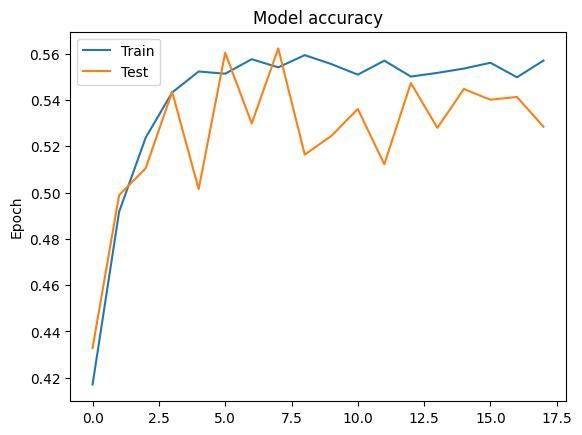

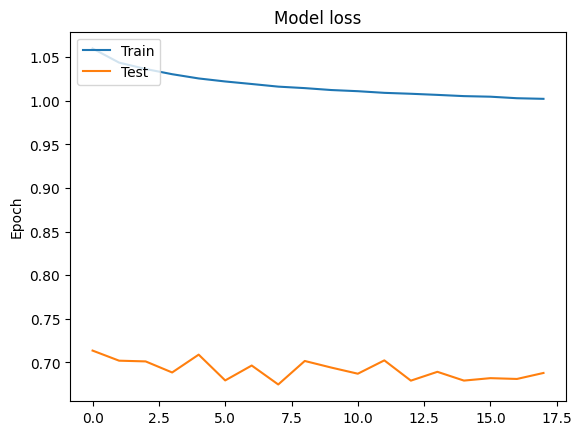

In [22]:
plot_history(history)

In [23]:
y_hat = model.predict(X_test)

313/313 [==============================] - 0s 427us/step


In [24]:
y_hat = y_hat.argmax(axis=1)

In [25]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.73      1.00      0.85      7337
           1       0.00      0.00      0.00      2650

    accuracy                           0.73      9987
   macro avg       0.37      0.50      0.42      9987
weighted avg       0.54      0.73      0.62      9987



/opt/homebrew/Caskroom/miniforge/base/envs/anyone/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/anyone/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/anyone/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

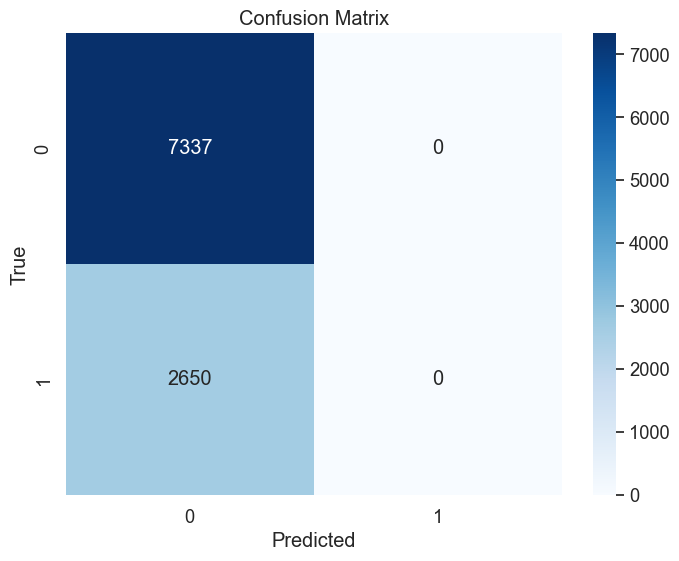

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# Assuming you have y_test and y_hat
# y_test: true labels
# y_hat: predicted labels

# Compute confusion matrix
cm = confusion_matrix(y_test, y_hat)

# Get class labels
class_labels = unique_labels(y_test, y_hat)

# Create a figure and axis
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size if needed

# Create a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Display the plot
plt.show()